In [1]:
## Importing necessary libraries
import sys
import sqlite3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

# defining functions module path
module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from functions import normalize, clean_data

In [2]:
# Getting the transactions data from sqlite
conn = sqlite3.connect("../data/bootcamp_db") # creating connection

In [3]:
# Quering the data from the online_transactions_fixed table
query = """
select *
from online_transactions_fixed
"""
ot = pd.read_sql(query, conn)

In [4]:
# The function clean_data performed a serie of cleaning steps defined on EDA notebook
online_trans = clean_data(ot)

In [5]:
online_trans.describe()

,old_index,quantity,price,total_order_value,invoice_year,invoice_month,invoice_day,invoice_weekday
count,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000,365180.000000
mean,201388.233230,12.879829,2.905252,21.919158,2010.934356,7.650090,15.011531,2.592034
std,115651.048694,43.577928,7.381186,95.735167,0.247660,3.405954,8.635549,1.920402
min,0.000000,1.000000,0.001000,0.001000,2010.000000,1.000000,1.000000,0.000000
25%,101147.750000,2.000000,1.250000,4.950000,2011.000000,5.000000,7.000000,1.000000
50%,202427.500000,6.000000,1.950000,11.900000,2011.000000,8.000000,15.000000,2.000000
75%,301305.250000,12.000000,3.750000,19.800000,2011.000000,11.000000,22.000000,4.000000
max,399806.000000,4800.000000,1599.260000,38970.000000,2011.000000,12.000000,31.000000,6.000000


#### In the previous notebook (EDA.ipynb) the data was grouped by customer id and the values of Recency, Frequency, and Monetary Value were computed. 
- Recency was defined as the difference between the current day and the day of the customer's last purchase. As the data is from 2011, and a customer whose recency is bigger than a year can be considered as churned, I chosed the "current day" as the last day of the last purchase on the data set, meaning that the minimum value that recency can take is 0.
- Frequency was define as the number of transactions that a customer performed.
- Monetary Value is simply the sum of the total order value per customer on the dataset

In [6]:
# Importing customer data
cust_data = pd.read_csv("../data/customer_data.csv")

In [7]:
cust_data.describe()

,loyalty_time,mean_nstock,mean_nitem,mon_value,frequency,recency
count,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000,4247.000000
mean,133.676948,21.560731,224.903868,1884.727573,85.985401,88.463386
std,132.639094,19.285931,305.002619,8210.321624,215.913912,98.735861
min,0.000000,1.000000,1.000000,0.850000,1.000000,0.000000
25%,0.000000,9.041667,90.583333,297.200000,16.000000,15.500000
50%,101.000000,16.500000,158.235294,635.680000,39.000000,46.000000
75%,257.000000,28.000000,265.483333,1534.090000,94.000000,134.000000
max,372.000000,300.647059,7824.000000,279138.020000,7499.000000,373.000000


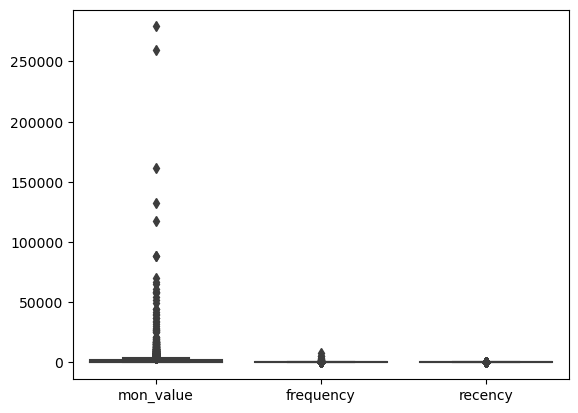

In [8]:
# Let's check the distribution of the RFM attributes
sns.boxplot(cust_data[['mon_value', 'frequency', 'recency']]);

#### It is shown in the plot above that the scales from the three main attributes of the RFM analysis are quite different. As next step, I will normalize them in order to be able to use them to calculate the RFM score

In [9]:
for col in cust_data:
    if col == 'customer_id':
        pass
    else:
        norm = normalize(cust_data[f"{col}"])
        col_name = col + "_norm"
        cust_data[f"{col_name}"] = norm

#### In order to take into account that the most valuable customer are the one with recency equal to zero, I will invert the scale of the normalization for this score. From now on the customer with recency equal to 1 are the ones whose last order date is most recently than the ones with recency equal to 0 who are the ones that ordered almost a year ago. 

In [10]:
# Inverting scale of the normalization just for recency
cust_data['recency_norm'] = 1 - cust_data['recency_norm']

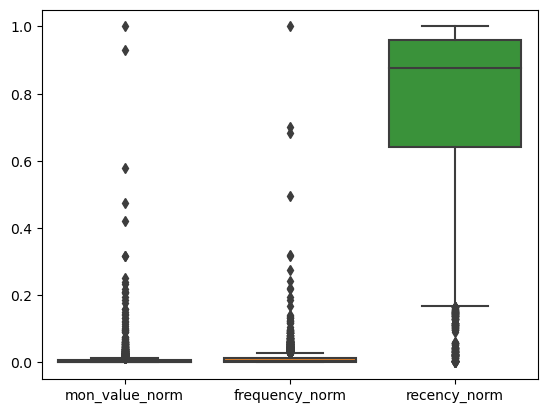

In [11]:
# Let's check the distribution of the RFM attributes this time normalized
sns.boxplot(cust_data[['mon_value_norm', 'frequency_norm', 'recency_norm']]);

#### Monetary value and Frequency are having quite a lot of outliers, they are less spread through the range than Recency. I will define my RFM score as: 

$RFM_{score} = W_{recency} * Recency + W_{frequency} * Frequency + W_{monetary} * Monetary $

$W_{recency}$, $W_{frequency}$ and $W_{monetary}$ will represent the respectively contribution of each attribute to the RFM score.

> <div class="alert alert-block alert-success">
<b>Assumption: </b>Since my data contain transactions puchased on a year, the recency will not be consider as important as the frequency or the monetary value. I will assume that my data comes from a well establish e-commerce, therefore I will focus on the segmentation of my customers giving an extra importance to the monetary value.
</div>

In [12]:
def cust_seg(data, W_R, W_F, W_M):
    # Function to obtain the customers' segments 
    # cust_data is a pandas data frame that contains "recency_norm", "frequency_norm" and mon_value_norm"
    # This are the normalized version of the recency, frequency and monetary value per customer
    # W_R, W_F, W_M are the weights for each attribute
    
    RFM_score = W_R * data['recency_norm'] + W_F * data['frequency_norm'] + W_M * data['mon_value_norm']
    data['RFM_score'] = RFM_score # adding RFM score to the customer dataset
    
    segment = []
    Q1, Q2, Q3 = RFM_score.quantile([0.2, .40, 0.8])
    
    for score in RFM_score:
        if score <= Q1:
            segment.append("A")
        elif Q1 < score <= Q2:
            segment.append("B")
        elif Q2 < score <= Q3:
            segment.append("C")
        else:
            segment.append("D")

    data['cust_segment'] = segment
    
    return data

In [13]:
cust_seg(cust_data, 0.1, 0.3, 0.6)

,customer_id,loyalty_time,mean_nstock,mean_nitem,mon_value,frequency,recency,loyalty_time_norm,mean_nstock_norm,mean_nitem_norm,mon_value_norm,frequency_norm,recency_norm,RFM_score,cust_segment
0,u12347,365,26.000000,351.142857,4310.00,182.0,1,0.981183,0.083431,0.044758,0.015437,0.024140,0.997319,0.116236,D
1,u12348,282,6.750000,583.000000,1437.24,27.0,74,0.758065,0.019189,0.074396,0.005146,0.003468,0.801609,0.084289,B
2,u12349,0,72.000000,630.000000,1457.55,72.0,18,0.000000,0.236945,0.080404,0.005219,0.009469,0.951743,0.101146,C
3,u1235,0,16.000000,196.000000,294.40,16.0,309,0.000000,0.050059,0.024926,0.001052,0.002001,0.171582,0.018389,A
4,u12352,260,11.000000,75.142857,1385.74,77.0,35,0.698925,0.033373,0.009478,0.004961,0.010136,0.906166,0.096634,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4242,u1828,0,10.000000,45.000000,180.60,10.0,277,0.000000,0.030035,0.005624,0.000644,0.001200,0.257373,0.026484,A
4243,u18281,0,7.000000,54.000000,80.82,7.0,180,0.000000,0.020024,0.006775,0.000286,0.000800,0.517426,0.052155,A
4244,u18282,114,6.000000,51.500000,178.05,12.0,7,0.306452,0.016686,0.006455,0.000635,0.001467,0.981233,0.098944,C
4245,u18283,333,44.937500,84.687500,2039.58,719.0,3,0.895161,0.146631,0.010698,0.007304,0.095759,0.991957,0.132306,D


In [14]:
# Let's chek the summary for each score
cust_data.loc[:, ["recency_norm", "frequency_norm", "mon_value_norm", "RFM_score"]].sort_values(by=['RFM_score']).describe()

,recency_norm,frequency_norm,mon_value_norm,RFM_score
count,4247.000000,4247.000000,4247.000000,4247.000000
mean,0.762833,0.011334,0.006749,0.083733
std,0.264707,0.028796,0.029413,0.037842
min,0.000000,0.000000,0.000000,0.000169
25%,0.640751,0.002001,0.001062,0.067168
50%,0.876676,0.005068,0.002274,0.091946
75%,0.958445,0.012403,0.005493,0.101510
max,1.000000,1.000000,1.000000,0.782114


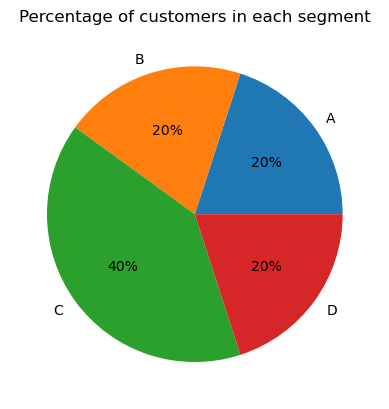

In [15]:
# Let's visualize the percentage of clients in each segment
plt.pie(cust_data.groupby('cust_segment')['customer_id'].count(), labels=['A', 'B', 'C', 'D'], autopct='%.0f%%')
plt.title("Percentage of customers in each segment");

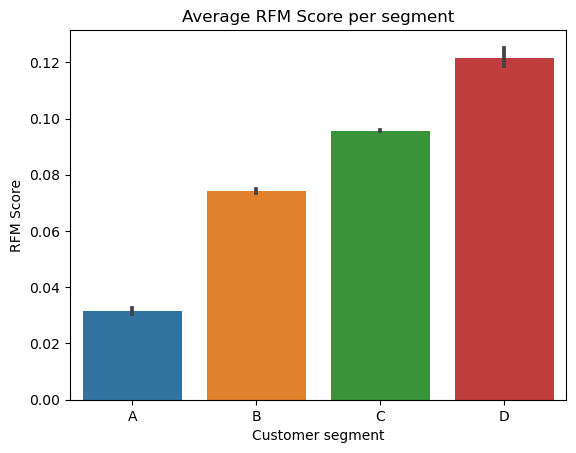

In [16]:
# Average RFM Score in each segment
sns.barplot(data=cust_data, x='cust_segment', y= 'RFM_score', order=['A', 'B', 'C', 'D'])
plt.xlabel('Customer segment')
plt.ylabel('RFM Score')
plt.title("Average RFM Score per segment");

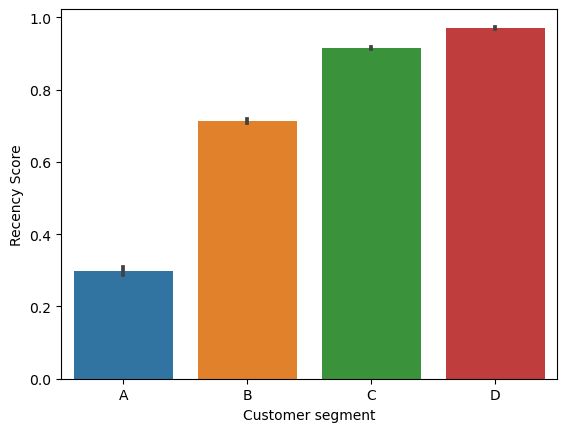

In [17]:
sns.barplot(data=cust_data, x="cust_segment", y="recency_norm", order=['A', 'B', 'C', 'D'])
plt.xlabel('Customer segment')
plt.ylabel('Recency Score');

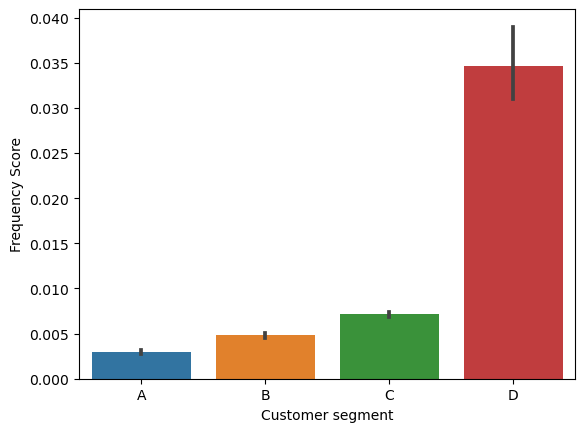

In [18]:
sns.barplot(data=cust_data, x="cust_segment", y="frequency_norm", order=['A', 'B', 'C', 'D'])
plt.xlabel('Customer segment')
plt.ylabel('Frequency Score');

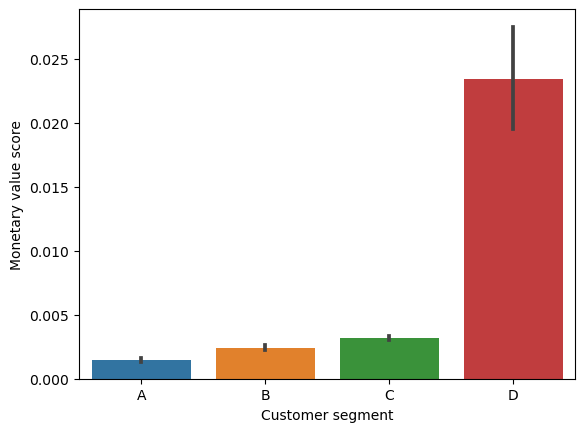

In [19]:
sns.barplot(data=cust_data, x="cust_segment", y="mon_value_norm", order=['A', 'B', 'C', 'D'])
plt.xlabel('Customer segment')
plt.ylabel('Monetary value score');

In [20]:
RFMmean_C = cust_data[cust_data['cust_segment'] == 'C']['RFM_score'].mean()
RFMmean_D = cust_data[cust_data['cust_segment'] == 'D']['RFM_score'].mean()
percRFM_CD = (RFMmean_D - RFMmean_C) * 100 / RFMmean_D
print(f"Customers on segment C have on average {round(percRFM_CD)}% smaller RFM than customers on segment D")


Customers on segment C have on average 21% smaller RFM than customers on segment D


#### After the segmentation of the customers and the previous visualizations can be concluded that:
- The segment D is the one with higher RFM which means that in this segments are the customers that are most valuable for company. In summary, customers with high monetary value (spent the most), high frequency (purchased more often), and high recency (purchased recently). They are gonna be label as the "High-Profit" customers.
- Customers in segment C are having in average RFM score 21% lower than customers on segment D. This is due to the fact that the recency for these customers is quite high but the frequency and the monetary values are considerably lower than customers on segment D. They are gonna be label as the "Medium-Profit" customers.
- The "Low-Profit" customers are gonna be the customers from segments A and B. Eventhough customers on segments B did purchased more recenly than customers on segment A, the moneatry value and the frequency of their purchases are comparable. As a matter of reference, I will label these two groups as Low-Profit-A and Low-Profit-B.

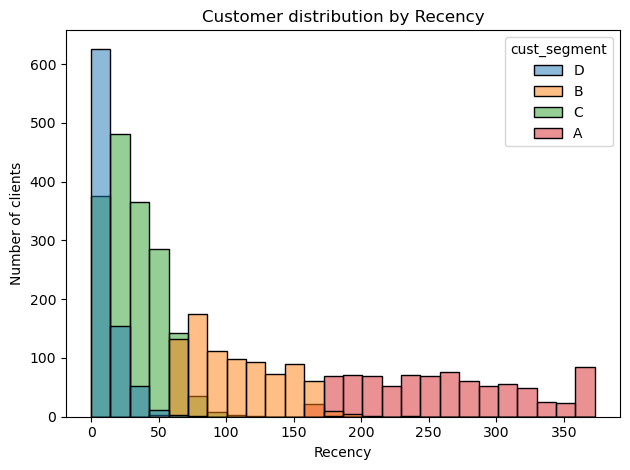

In [21]:
# Customer distribution by recency and segment
sns.histplot(data=cust_data, x='recency', hue='cust_segment')#, element="step", palette="tab10")
plt.title("Customer distribution by Recency")
plt.xlabel("Recency")
plt.ylabel("Number of clients")
plt.tight_layout()

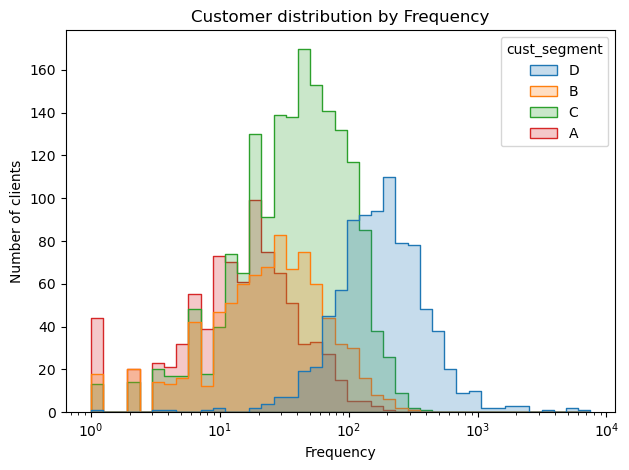

In [22]:
# Customer distribution by frequency and segment
sns.histplot(data=cust_data, x='frequency', hue='cust_segment', element="step", palette="tab10", log_scale=True)
plt.title("Customer distribution by Frequency")
plt.xlabel("Frequency")
plt.ylabel("Number of clients")
plt.tight_layout()

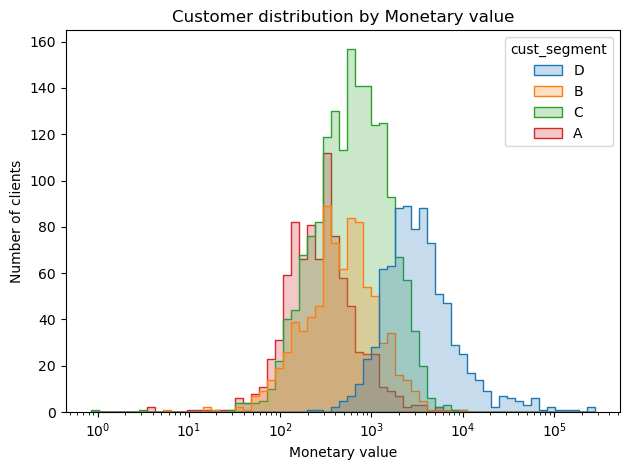

In [23]:
# Customer distribution by monetary value and segment
sns.histplot(data=cust_data, x='mon_value', hue='cust_segment', element="step", palette="tab10", log_scale=True)
plt.title("Customer distribution by Monetary value")
plt.xlabel("Monetary value")
plt.ylabel("Number of clients")
plt.tight_layout()

#### Let's merge the customer data with the online transactions dataset to get the transactions labeled with the corresponding customer segment

In [24]:
# Mergind online transactions dataset with customer dataset
merged_df = pd.merge(online_trans, cust_data, on='customer_id', how='left')

In [25]:
# Number of invoices per month
monthly_data = merged_df.groupby(["cust_segment", "invoice_month", "invoice_year"]).count()['invoice'].reset_index()

## TO DO! Add in the plot above the sum of the 4 lineplots (num of invoice as a function of time)

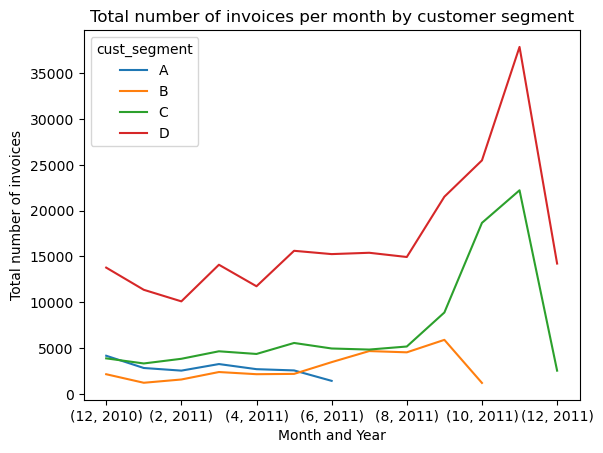

In [26]:
monthly_data.pivot_table('invoice', index=['invoice_month', 'invoice_year'], columns='cust_segment', aggfunc='sum').sort_values(by='invoice_year').plot(kind='line')
plt.xlabel("Month and Year")
plt.ylabel("Total number of invoices")
plt.title("Total number of invoices per month by customer segment");

### In the previous visualization is clearly visible the customer's behaviour as a function of time in each of the segments

In [27]:
ordered_days = merged_df[['invoice_weekday', 'invoice_dayname']].sort_values(by='invoice_weekday')['invoice_dayname'].unique()

In [28]:
# Getting the number of invoices per day of the week
weekly_inv = merged_df.groupby(["cust_segment", "invoice_weekday", 'invoice_dayname']).count()['invoice'].reset_index().sort_values(by='invoice_weekday')

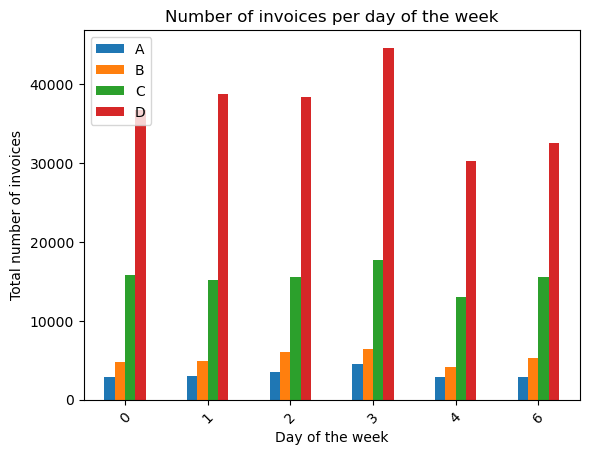

In [29]:
weekly_inv.pivot_table('invoice', index=['invoice_weekday'], columns='cust_segment', aggfunc='sum').plot(kind='bar')
plt.title("Number of invoices per day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Total number of invoices")
plt.xticks(rotation=45)
plt.legend(loc='upper left');

#### The number of invoices per day of the week is relatively stable for each customer segment

In [30]:
daily_inv = merged_df.groupby(["cust_segment", "invoice_day"]).count()['invoice'].reset_index()

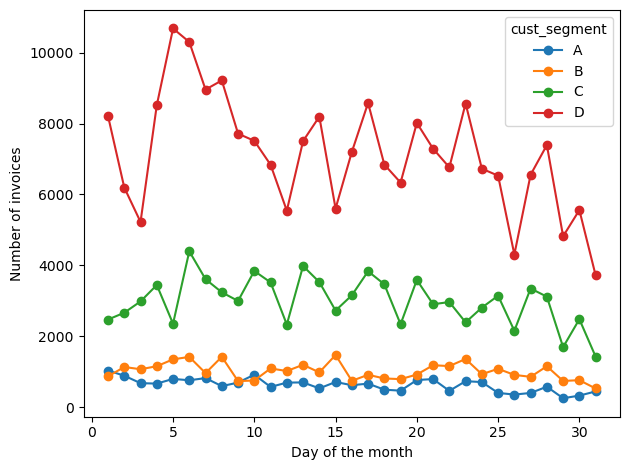

In [31]:
daily_inv.pivot_table('invoice', index=['invoice_day'], columns='cust_segment', aggfunc='sum').plot(kind='line', marker='o')
plt.xlabel("Day of the month")
plt.ylabel("Number of invoices")
plt.tight_layout();

#### In the previous plot it is clear that our customers are segmented in three main groups. A represents the customers that are purchasing the most and therefore generating more income to the company. Segment B represents the customers with mid value and C the ones purchasing the least.

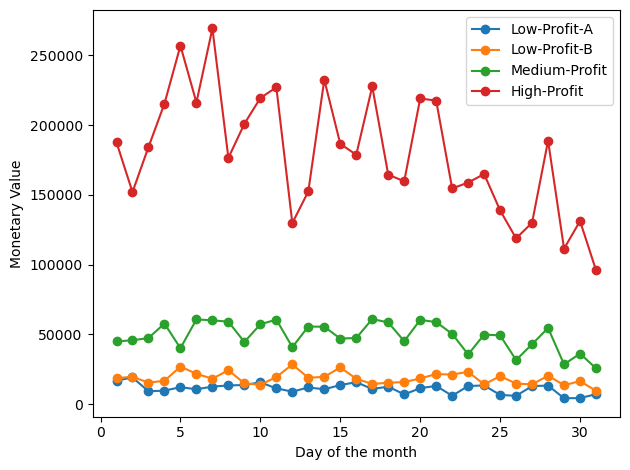

In [32]:
label = ["Low-Profit-A", "Low-Profit-B", "Medium-Profit", "High-Profit"]
tot_val_daily = merged_df.groupby(["cust_segment", "invoice_day"])['total_order_value'].sum().reset_index()
ax = tot_val_daily.pivot_table('total_order_value', index=['invoice_day'], columns='cust_segment', aggfunc='sum').plot(kind='line', marker='o', label=label)
plt.xlabel("Day of the month")
plt.ylabel("Monetary Value")
plt.legend(labels=label)
plt.tight_layout();